In [69]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
from scipy.linalg import expm
import pandas as pd

resol = 200
pi = np.pi
version_table()

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> Model </h1>

I consider the scattering of only one photon towards a 2-level atom. Also, I assume that several atoms might be in the waveguide (to play the role of a mirror for instance). I work in the subspace :

$$ \ket{1,0}, \ket{0,1} $$

And the Hamiltonian is given by: 

$$ H = \sum_k \omega_k a_k^{\dagger} a_k + \frac{1}{2} \sum_j \Omega_j (1 + \sigma_j^z) + \sum_{k,j}\left\{g(k,j) \sigma^+ a_k + \text{h.c} \right\} $$

with $g(k,j) = i g_0 \sqrt{\omega_k} e^{ikx_j}$

<h1> Conduct time evolution </h1>

In [70]:
def get_data_mirror(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, use_WW_approx = True, print_nb_modes = False):
    #quantization of the modes
    omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
    omega_tab = np.abs(k_tab)
    n_modes = len(k_tab)
    if print_nb_modes:
        print("Number of modes: ", n_modes)

    #Creation of the Hamiltonian
    dim_subspace = n_modes + 1
    H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)

    print("Preparing the Hamiltonian ...")
    ##diagonal elements
    for i in range(n_modes):
        H_matrix[i, i] = omega_tab[i]
    
        if use_WW_approx:
        ##off diagonal elements
            H_matrix[n_modes, i] = g_0*np.sqrt(omega_A / L)*1j
        else:
            H_matrix[n_modes, i] = g_0*np.sqrt(omega_tab[i] / L)*1j
        H_matrix[i,n_modes] = np.conjugate(H_matrix[n_modes,i])
    
    H_matrix[n_modes, n_modes] = omega_A

    H = qt.Qobj(H_matrix)
    #hermicity check
    if not H.isherm:
        print("Hermicity of the Hamiltonian: ", H.isherm)
        return None
    #also obtain the free hamiltonian
    H_free = qt.Qobj(np.diag(np.diag(H_matrix)))

    print("Initializing the state ...")
    ##Initial state
    k_bar = k_tab[np.argmin(np.abs(k_tab - omega_0))]
    x_bar = x_0

    init_state = 0
    for i in range(n_modes): ##only the modes with positive momentum are excited at the beginning
        coef = np.exp(-0.5*sigma**2*(k_tab[i] - k_bar)**2 -1j * k_tab[i] * x_bar)
        init_state += coef * qt.basis(dim_subspace, i)
    init_state = init_state.unit()
    
    print("Launching the time evolution ...")
    #time evolution
    n_step = int(T/dt)
    times = np.linspace(0, T, n_step)
    result = qt.sesolve(H, init_state, times, options={"nsteps":10000, "progress_bar": True, "store_states": True})
    state_list = result.states

    #also get the free evolution of the initial state
    result_free = qt.sesolve(H_free, init_state, times, options={"nsteps":10000, "store_states": True})
    state_list_free = result_free.states
    
    #Extracting the populations of the modes and the atom
    N_k_t = np.zeros((n_modes, n_step))
    N_A_t = np.zeros(n_step)
    overlap_free_evol = np.zeros(n_step)


    print("Computing occupation numbers in momentum space...")
    for t in tqdm(range(n_step)):
        current_state = state_list[t]

        for i in range(n_modes):
            momentum_state = qt.basis(dim_subspace, i)
            N_k_t[i, t] = np.abs(momentum_state.dag() * current_state)**2

        atomic_state = qt.basis(dim_subspace, n_modes)
        N_A_t[t] += np.abs(atomic_state.dag() * current_state)**2
        
        overlap_free_evol[t] = np.abs(state_list_free[t].dag() * current_state)**2

    return times, k_tab, N_k_t, N_A_t, overlap_free_evol

<h1> First test </h1>

Check the parameters first

In [71]:
L = 250*pi
T = L/2
dt = 0.1

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 0.1
omega_A = 3
gamma = 2*g_0**2*omega_A

#initial photon wavepacket parameters
sigma = L/16
sigma_momentum = 1/sigma
x_0 = -L/4
omega_0 = omega_A - 0.1

#numerical implementation of momentum space
omega_max = 10

print("Coupling g(k,j): ", g_0*np.sqrt(omega_A / L))
print("sigma_momentum: ", sigma_momentum)
print("Decay rate gamma: ", gamma)


Coupling g(k,j):  0.006180387232371035
sigma_momentum:  0.020371832715762605
Decay rate gamma:  0.06000000000000001


Now, run the function

In [72]:
times, k_tab, N_k_t, N_A_t, overlap_free_evol = get_data_mirror(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, print_nb_modes = True)

Number of modes:  2501
Preparing the Hamiltonian ...
Initializing the state ...
Launching the time evolution ...
10.0%. Run time:   3.01s. Est. time left: 00:00:00:27
20.0%. Run time:   6.16s. Est. time left: 00:00:00:24
30.0%. Run time:   9.28s. Est. time left: 00:00:00:21
40.0%. Run time:  11.83s. Est. time left: 00:00:00:17
50.0%. Run time:  14.50s. Est. time left: 00:00:00:14
60.0%. Run time:  17.01s. Est. time left: 00:00:00:11
70.0%. Run time:  20.36s. Est. time left: 00:00:00:08
80.0%. Run time:  23.49s. Est. time left: 00:00:00:05
90.0%. Run time:  26.51s. Est. time left: 00:00:00:02
100.0%. Run time:  30.23s. Est. time left: 00:00:00:00
Total run time:  30.23s
Computing occupation numbers in momentum space...


  0%|          | 0/3926 [00:00<?, ?it/s]

<h1> R and T coefficients </h1>

Try to define reflection and transmission cofficients ? Let me define:

$N_k = a_k^{\dagger} a_k$ and $N_x = a_x^{\dagger} a_x$ where :

$$a_x = \frac{1}{\sqrt{N}} \sum_k e^{ikx} a_k$$

I can define : 

$$P_-(t) = \sum_{k < 0} N_k \,\, , \,\, P_+(t) = \sum_{k > 0} N_k $$

It is also interesting to check that the atomic number remains close to zero :

$$ N_A = \sum_j \left(\frac{1+\sigma_j^z}{2}\right)$$

The transmission coefficient is $T = P_+(\infty)$ and the reflection is $R = P_-(\infty)$

Results from summation per modes
T =  0.6273653089807253
R =  0.36318149093116564
Final occupation of the atom =  0.009453200088106581
---------------------------------------------------------
Results from overlap
T =  0.40803101058932156
R =  0.5825157893225719
Final occupation of the atom =  0.009453200088106581


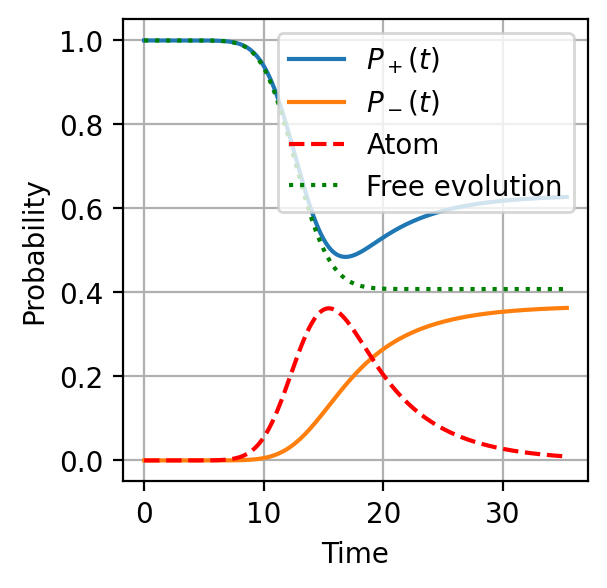

In [68]:
n_modes = N_k_t.shape[0]

nb_pts = len(times)
P_p = np.zeros(nb_pts)
P_m = np.zeros(nb_pts)

for t in range(nb_pts):
    for i in range(n_modes): 
        if k_tab[i] > 0:
            P_p[t] += N_k_t[i,t]
        else:
            P_m[t] += N_k_t[i,t]


print("Results from summation per modes")
print("T = ", P_p[-1])
print("R = ", P_m[-1])
print("Final occupation of the atom = ", N_A_t[-1])
print("---------------------------------------------------------")
print("Results from overlap")
print("T = ", overlap_free_evol[-1])
print("R = ", 1- overlap_free_evol[-1]- N_A_t[-1])
print("Final occupation of the atom = ", N_A_t[-1]) 


fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(times, P_p, label=r'$P_+(t)$')
ax.plot(times, P_m, label=r'$P_-(t)$')
#ax.plot(times, P_p+P_m, label=r'$P_+ + P_-$', linestyle='--', alpha=0.5) 
ax.plot(times, N_A_t, label='Atom', linestyle='--', color='red')   
ax.plot(times, overlap_free_evol, label='Free evolution', linestyle=':', color='green')
ax.set_xlabel('Time')
ax.set_ylabel('Probability')
ax.legend()
ax.grid()

plt.show()

<h1> Choose atomic frequency </h1>

In [76]:
L_tab = np.array([10, 50, 100, 150, 200, 250, 300]) * pi

for x in tqdm(range(len(L_tab))):
    L = L_tab[x]
    T = L/2
    dt = 0.1

    #Jaynes-Cummings parameter g_0 and energies 
    g_0 = 0.1
    omega_A = 3
    gamma = 2*g_0**2*omega_A

    #initial photon wavepacket parameters
    sigma = L/16
    sigma_momentum = 1/sigma
    x_0 = -L/4
    omega_0 = omega_A - 0.01

    #numerical implementation of momentum space
    omega_max = 10
    times, k_tab, N_k_t, N_A_t, overlap_free_evol = get_data_mirror(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, print_nb_modes = False)

    #save the current results
    times_to_save = pd.Series(times)
    N_A_t_to_save = pd.Series(N_A_t)

    times_to_save.to_csv(f'./result_choice_L/times_L_{x}.csv', index=False)
    N_A_t_to_save.to_csv(f'./result_choice_L/N_A_t_L_{x}.csv', index=False)


  0%|          | 0/7 [00:00<?, ?it/s]

Preparing the Hamiltonian ...
Initializing the state ...
Launching the time evolution ...
10.3%. Run time:   0.00s. Est. time left: 00:00:00:00
20.5%. Run time:   0.00s. Est. time left: 00:00:00:00
30.1%. Run time:   0.01s. Est. time left: 00:00:00:00
40.4%. Run time:   0.01s. Est. time left: 00:00:00:00
50.0%. Run time:   0.01s. Est. time left: 00:00:00:00
60.3%. Run time:   0.01s. Est. time left: 00:00:00:00
70.5%. Run time:   0.01s. Est. time left: 00:00:00:00
80.1%. Run time:   0.02s. Est. time left: 00:00:00:00
90.4%. Run time:   0.02s. Est. time left: 00:00:00:00
100.0%. Run time:   0.02s. Est. time left: 00:00:00:00
Total run time:   0.02s
Computing occupation numbers in momentum space...


  0%|          | 0/157 [00:00<?, ?it/s]

Preparing the Hamiltonian ...
Initializing the state ...
Launching the time evolution ...
10.1%. Run time:   0.06s. Est. time left: 00:00:00:00
20.0%. Run time:   0.12s. Est. time left: 00:00:00:00
30.1%. Run time:   0.17s. Est. time left: 00:00:00:00
40.1%. Run time:   0.23s. Est. time left: 00:00:00:00
50.0%. Run time:   0.27s. Est. time left: 00:00:00:00
60.1%. Run time:   0.32s. Est. time left: 00:00:00:00
70.0%. Run time:   0.39s. Est. time left: 00:00:00:00
80.1%. Run time:   0.48s. Est. time left: 00:00:00:00
90.1%. Run time:   0.58s. Est. time left: 00:00:00:00
100.0%. Run time:   0.60s. Est. time left: 00:00:00:00
Total run time:   0.60s
Computing occupation numbers in momentum space...


  0%|          | 0/785 [00:00<?, ?it/s]

Preparing the Hamiltonian ...
Initializing the state ...
Launching the time evolution ...
10.0%. Run time:   0.16s. Est. time left: 00:00:00:01
20.0%. Run time:   0.36s. Est. time left: 00:00:00:01
30.0%. Run time:   0.61s. Est. time left: 00:00:00:01
40.0%. Run time:   0.95s. Est. time left: 00:00:00:01
50.0%. Run time:   1.20s. Est. time left: 00:00:00:01
60.0%. Run time:   1.36s. Est. time left: 00:00:00:00
70.0%. Run time:   1.62s. Est. time left: 00:00:00:00
80.1%. Run time:   1.80s. Est. time left: 00:00:00:00
90.1%. Run time:   2.08s. Est. time left: 00:00:00:00
100.0%. Run time:   2.29s. Est. time left: 00:00:00:00
Total run time:   2.29s
Computing occupation numbers in momentum space...


  0%|          | 0/1570 [00:00<?, ?it/s]

Preparing the Hamiltonian ...
Initializing the state ...
Launching the time evolution ...
10.0%. Run time:   0.54s. Est. time left: 00:00:00:04
20.0%. Run time:   1.13s. Est. time left: 00:00:00:04
30.0%. Run time:   1.69s. Est. time left: 00:00:00:03
40.0%. Run time:   2.42s. Est. time left: 00:00:00:03
50.0%. Run time:   3.07s. Est. time left: 00:00:00:03
60.0%. Run time:   3.78s. Est. time left: 00:00:00:02
70.0%. Run time:   4.53s. Est. time left: 00:00:00:01
80.0%. Run time:   5.38s. Est. time left: 00:00:00:01
90.0%. Run time:   5.97s. Est. time left: 00:00:00:00
100.0%. Run time:   6.62s. Est. time left: 00:00:00:00
Total run time:   6.62s
Computing occupation numbers in momentum space...


  0%|          | 0/2356 [00:00<?, ?it/s]

Preparing the Hamiltonian ...
Initializing the state ...
Launching the time evolution ...
10.0%. Run time:   1.61s. Est. time left: 00:00:00:14
20.0%. Run time:   3.06s. Est. time left: 00:00:00:12
30.0%. Run time:   4.48s. Est. time left: 00:00:00:10
40.0%. Run time:   6.05s. Est. time left: 00:00:00:09
50.0%. Run time:   7.51s. Est. time left: 00:00:00:07
60.0%. Run time:   8.92s. Est. time left: 00:00:00:05
70.0%. Run time:  10.30s. Est. time left: 00:00:00:04
80.0%. Run time:  11.85s. Est. time left: 00:00:00:02
90.0%. Run time:  13.46s. Est. time left: 00:00:00:01
100.0%. Run time:  15.06s. Est. time left: 00:00:00:00
Total run time:  15.06s
Computing occupation numbers in momentum space...


  0%|          | 0/3141 [00:00<?, ?it/s]

Preparing the Hamiltonian ...
Initializing the state ...
Launching the time evolution ...
10.0%. Run time:   2.36s. Est. time left: 00:00:00:21
20.0%. Run time:   4.86s. Est. time left: 00:00:00:19
30.0%. Run time:   7.18s. Est. time left: 00:00:00:16
40.0%. Run time:   9.48s. Est. time left: 00:00:00:14
50.0%. Run time:  11.73s. Est. time left: 00:00:00:11
60.0%. Run time:  13.99s. Est. time left: 00:00:00:09
70.0%. Run time:  16.32s. Est. time left: 00:00:00:06
80.0%. Run time:  18.63s. Est. time left: 00:00:00:04
90.0%. Run time:  21.04s. Est. time left: 00:00:00:02
100.0%. Run time:  23.27s. Est. time left: 00:00:00:00
Total run time:  23.27s
Computing occupation numbers in momentum space...


  0%|          | 0/3926 [00:00<?, ?it/s]

Preparing the Hamiltonian ...
Initializing the state ...
Launching the time evolution ...
10.0%. Run time:   3.53s. Est. time left: 00:00:00:31
20.0%. Run time:   6.92s. Est. time left: 00:00:00:27
30.0%. Run time:  10.25s. Est. time left: 00:00:00:23
40.0%. Run time:  13.65s. Est. time left: 00:00:00:20
50.0%. Run time:  16.98s. Est. time left: 00:00:00:16
60.0%. Run time:  20.34s. Est. time left: 00:00:00:13
70.0%. Run time:  23.68s. Est. time left: 00:00:00:10
80.0%. Run time:  26.99s. Est. time left: 00:00:00:06
90.0%. Run time:  30.31s. Est. time left: 00:00:00:03
100.0%. Run time:  33.67s. Est. time left: 00:00:00:00
Total run time:  33.67s
Computing occupation numbers in momentum space...


  0%|          | 0/4712 [00:00<?, ?it/s]

Recover the data and plot the results

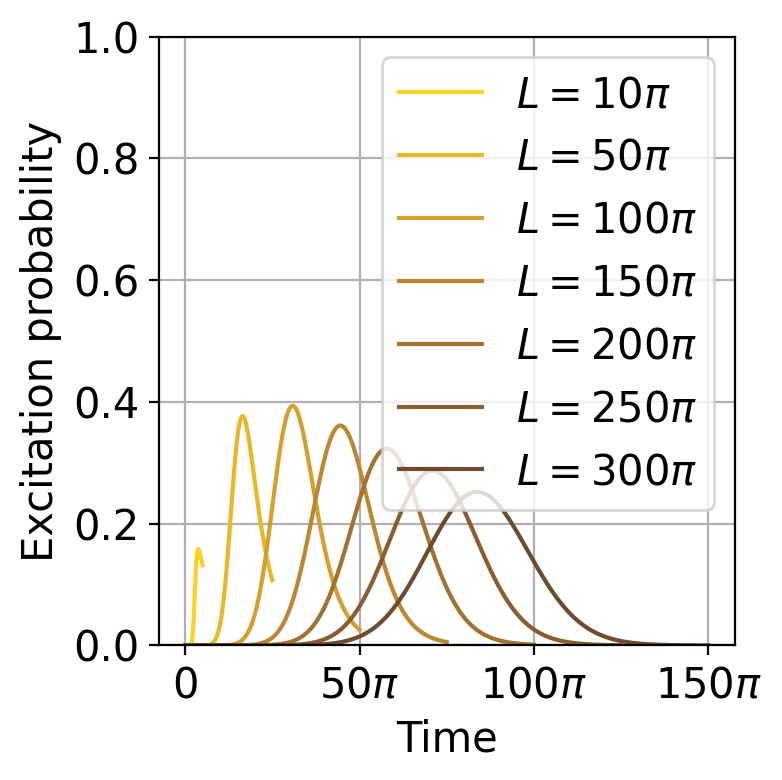

In [94]:
nb_pts_eff = 7
colors_tab = ["#6d4b2d","#885e30","#a37231","#bc8730","#d49f2e","#eab729","#ffd122"]

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=resol)
for x in range(nb_pts_eff):
    #recover the data in the csv files
    times_to_load = pd.read_csv(f'./result_choice_L/times_L_{x}.csv')
    N_A_t_to_load = pd.read_csv(f'./result_choice_L/N_A_t_L_{x}.csv')
    times = times_to_load['0'].values
    N_A_t = N_A_t_to_load['0'].values
    ax.plot(times, N_A_t, label=f'$L = {L_tab[x]/pi:.0f}\\pi$', color=colors_tab[7-1-x])

ax.set_ylim(0, 1)
ax.set_xticks(np.array([0, 50*pi, 100*pi, 150*pi]))
ax.set_xticklabels([r'$0$', r'$50\pi$', r'$100\pi$', r'$150\pi$'])

ax.set_xlabel('Time')
ax.set_ylabel('Excitation probability')
ax.grid()


ax.legend(prop={'size': 15})

#font size
for item in [ax.xaxis.label, ax.yaxis.label]:
    item.set_fontsize(15)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

fig.tight_layout()
plt.savefig('atom_excitation_vs_time.pdf', bbox_inches='tight')
plt.show()

Also show the final values

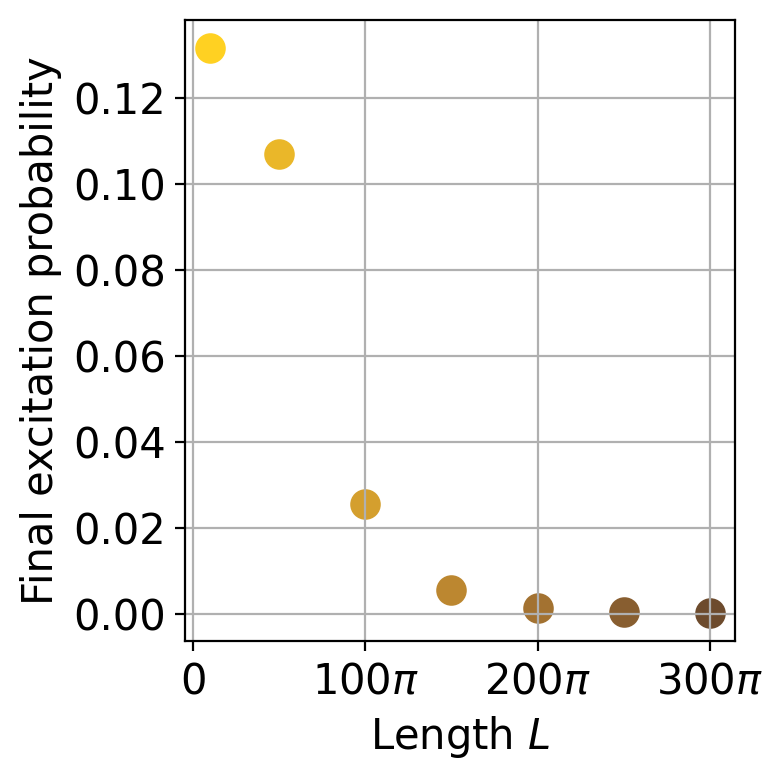

In [103]:
nb_pts_eff = 7
colors_tab = ["#6d4b2d","#885e30","#a37231","#bc8730","#d49f2e","#eab729","#ffd122"]
L_tab = np.array([10, 50, 100, 150, 200, 250, 300]) * pi

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=resol)
for x in range(nb_pts_eff):
    #recover the data in the csv files
    N_A_t_to_load = pd.read_csv(f'./result_choice_L/N_A_t_L_{x}.csv')
    N_a_t_final = N_A_t_to_load['0'].values[-1]
    ax.scatter([L_tab[x]], [N_a_t_final], color=colors_tab[7-1-x], s=100)

#ax.set_ylim(0, 1)
ax.set_xticks(np.array([0, 100*pi, 200*pi, 300*pi]))
ax.set_xticklabels([r'$0$', r'$100\pi$', r'$200\pi$', r'$300\pi$'])

ax.set_xlabel('Length $L$')
ax.set_ylabel('Final excitation probability')
ax.grid()


#font size
for item in [ax.xaxis.label, ax.yaxis.label]:
    item.set_fontsize(15)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

fig.tight_layout()
plt.savefig('atom_final_vs_L.pdf', bbox_inches='tight')
plt.show()

<h2> Occupation number of one specific mode </h2>

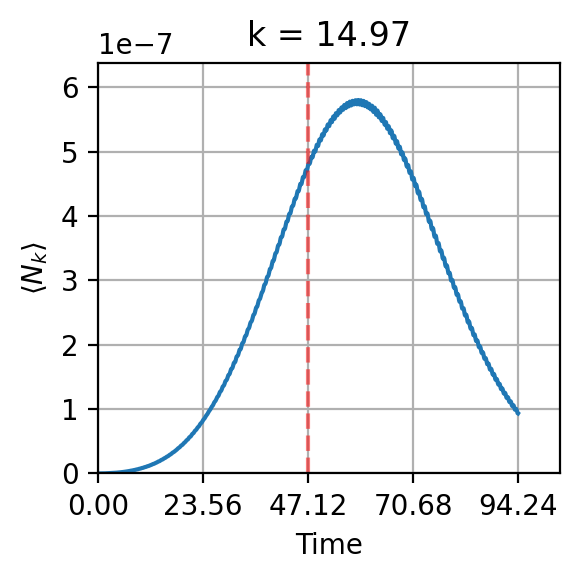

In [80]:
k_target = 6*omega_0
k_index = np.argmin(np.abs(k_tab - k_target))

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)

ax.plot(times, N_k_t[k_index,:])
ax.set_xlim(0, 1.1*times[-1])
ax.set_xticks(np.floor(100*np.array([0, T/4, T/2, 3*T/4, T]))/100)
ax.set_xlabel('Time')
ax.vlines(T/2, 0, 1, color='r', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1.1*np.max(N_k_t[k_index,:]))
ax.set_ylabel(r'$\langle N_k \rangle$')
ax.set_title("k = {:.2f}".format(k_tab[k_index]))
ax.grid()

fig.tight_layout()
plt.show()

<h1> UV Cut-off </h1>

Apparently, the UV cutoff has its importance ... let's check it. First; I rearrange my function to get only the final reflection coefficient and the final atomic occupation number

In [3]:
def get_data_mirror_UV_simu(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, use_WW_approx = True, print_nb_modes = False):
    #quantization of the modes
    omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
    omega_tab = np.abs(k_tab)
    n_modes = len(k_tab)
    if print_nb_modes:
        print("Number of modes: ", n_modes)

    #Creation of the Hamiltonian
    dim_subspace = n_modes + 1
    H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)

    print("Preparing the Hamiltonian ...")
    ##diagonal elements
    for i in range(n_modes):
        H_matrix[i, i] = omega_tab[i]
    
        if use_WW_approx:
        ##off diagonal elements
            H_matrix[n_modes, i] = g_0*np.sqrt(omega_A / L)*1j
        else:
            H_matrix[n_modes, i] = g_0*np.sqrt(omega_tab[i] / L)*1j
        H_matrix[i,n_modes] = np.conjugate(H_matrix[n_modes,i])
    
    H_matrix[n_modes, n_modes] = omega_A

    H = qt.Qobj(H_matrix)
    #hermicity check
    if not H.isherm:
        print("Hermicity of the Hamiltonian: ", H.isherm)
        return None
    #also obtain the free hamiltonian
    H_free = qt.Qobj(np.diag(np.diag(H_matrix)))

    print("Initializing the state ...")
    ##Initial state
    k_bar = k_tab[np.argmin(np.abs(k_tab - omega_0))]
    x_bar = x_0

    init_state = 0
    for i in range(n_modes): ##only the modes with positive momentum are excited at the beginning
        coef = np.exp(-0.5*sigma**2*(k_tab[i] - k_bar)**2 -1j * k_tab[i] * x_bar)
        init_state += coef * qt.basis(dim_subspace, i)
    init_state = init_state.unit()
    
    print("Launching the time evolution ...")
    #time evolution
    n_step = int(T/dt)
    times = np.linspace(0, T, n_step)
    result = qt.sesolve(H, init_state, times, options={"nsteps":10000, "progress_bar": True, "store_states": True})
    state_list = result.states

    #also get the free evolution of the initial state
    result_free = qt.sesolve(H_free, init_state, times, options={"nsteps":10000, "store_states": True})
    state_list_free = result_free.states
    
    #Extracting the populations of the modes and the atom at final time
    final_state = state_list[-1]
    final_state_free = state_list_free[-1]

    R_coef = 0
    T_coef = 0
    print("Computing the final quantities of interest ...")
    for i in range(n_modes):
        momentum_state = qt.basis(dim_subspace, i)
        N_k_final = np.abs(momentum_state.dag() * final_state)**2
        if k_tab[i] > 0:
            T_coef += N_k_final
        else:
            R_coef += N_k_final

    atomic_state = qt.basis(dim_subspace, n_modes)
    N_A_final = np.abs(atomic_state.dag() * final_state)**2
        
    final_free_overlap = np.abs(final_state_free.dag() * final_state)**2

    return R_coef, T_coef, N_A_final, final_free_overlap

Then, perform simulations for several UV cutoff

In [4]:
L = 250*pi
T = L/2
dt = 0.1

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 0.1
omega_A = 3
gamma = 2*g_0**2*omega_A

#initial photon wavepacket parameters
sigma = L/16
sigma_momentum = 1/sigma
x_0 = -L/4
omega_0 = 2.99 #almost resonant with the atom


nb_freq = 20
omega_max_tab = np.linspace(2*omega_A, 11, nb_freq)

reflection_tab = np.zeros(nb_freq)
transmission_tab = np.zeros(nb_freq)
N_A_final_tab = np.zeros(nb_freq)
overlap_free_evol_tab = np.zeros(nb_freq)


for x in tqdm(range(nb_freq)):
    omega_max = omega_max_tab[x]
    R_coef, T_coef, N_A_final, final_free_overlap  = get_data_mirror_UV_simu(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, print_nb_modes = True)

    reflection_tab[x] = R_coef
    transmission_tab[x] = T_coef
    N_A_final_tab[x] = N_A_final
    overlap_free_evol_tab[x] = final_free_overlap
    #Save the results at each iteration
    data = {
        'omega_max': omega_max,
        'reflection': R_coef,
        'transmission': T_coef,
        'N_A_final': N_A_final,
        'overlap_free_evol': final_free_overlap
    }
    df = pd.DataFrame(data, index=[0])
    current_filename = f"./results_UVcutoff/results_{x}.csv"
    df.to_csv(current_filename, index=False)


    

  0%|          | 0/20 [00:00<?, ?it/s]

Number of modes:  1501
Preparing the Hamiltonian ...
Initializing the state ...
Launching the time evolution ...
10.0%. Run time:   0.62s. Est. time left: 00:00:00:05
20.0%. Run time:   1.18s. Est. time left: 00:00:00:04
30.0%. Run time:   1.73s. Est. time left: 00:00:00:04
40.0%. Run time:   2.35s. Est. time left: 00:00:00:03
50.0%. Run time:   2.92s. Est. time left: 00:00:00:02
60.0%. Run time:   3.52s. Est. time left: 00:00:00:02
70.0%. Run time:   4.09s. Est. time left: 00:00:00:01
80.0%. Run time:   4.72s. Est. time left: 00:00:00:01
90.0%. Run time:   5.26s. Est. time left: 00:00:00:00
100.0%. Run time:   5.83s. Est. time left: 00:00:00:00
Total run time:   5.83s
Computing the final quantities of interest ...
Number of modes:  1565
Preparing the Hamiltonian ...
Initializing the state ...
Launching the time evolution ...
10.0%. Run time:   0.69s. Est. time left: 00:00:00:06
20.0%. Run time:   1.39s. Est. time left: 00:00:00:05
30.0%. Run time:   2.01s. Est. time left: 00:00:00:04


Treat the results

In [74]:
nb_freq_eff = 20

omega_max_tab = np.zeros(nb_freq_eff)

reflection_tab = np.zeros(nb_freq_eff)
transmission_tab = np.zeros(nb_freq_eff)
N_A_final_tab = np.zeros(nb_freq_eff)
overlap_free_evol_tab = np.zeros(nb_freq_eff)

for x in range(nb_freq_eff):
    #recover the associated csv file
    current_filename = f"./results_UVcutoff/results_{x}.csv"
    df = pd.read_csv(current_filename)

    omega_max_tab[x] = df['omega_max'][0]

    reflection_tab[x] = df['reflection'][0]
    transmission_tab[x] = df['transmission'][0]
    N_A_final_tab[x] = df['N_A_final'][0]
    overlap_free_evol_tab[x] = df['overlap_free_evol'][0]


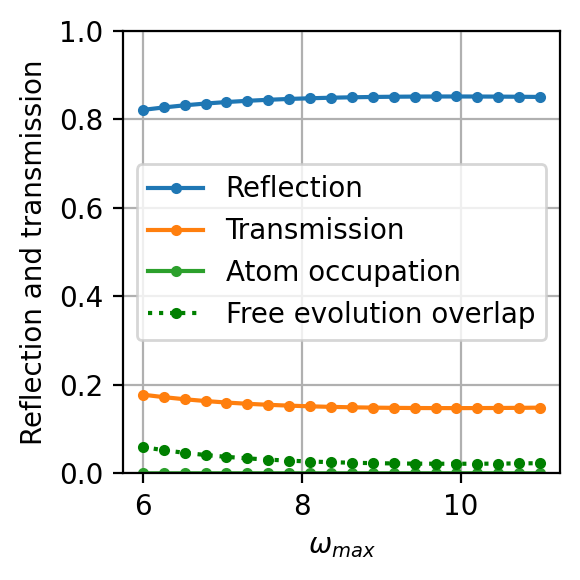

In [75]:
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(omega_max_tab, reflection_tab, markersize=3, marker='o', label='Reflection')
ax.plot(omega_max_tab, transmission_tab, markersize=3, marker='o', label='Transmission')
ax.plot(omega_max_tab, N_A_final_tab, markersize=3, marker='o', label='Atom occupation')
ax.plot(omega_max_tab, overlap_free_evol_tab, markersize=3, marker='o', label='Free evolution overlap', linestyle=':', color='green')
ax.set_xlabel(r'$\omega_{max}$')
ax.set_ylabel("Reflection and transmission")
ax.grid()
ax.legend()
ax.set_ylim(0, 1)

fig.tight_layout()
plt.show()

<h1> 50/50 Beamsplitter </h1>

In [56]:
def get_data_mirror_reflection(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, use_WW_approx = True, print_nb_modes = False):
    #quantization of the modes
    omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
    omega_tab = np.abs(k_tab)
    n_modes = len(k_tab)
    if print_nb_modes:
        print("Number of modes: ", n_modes)

    #Creation of the Hamiltonian
    dim_subspace = n_modes + 1
    H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)

    print("Preparing the Hamiltonian ...")
    ##diagonal elements
    for i in range(n_modes):
        H_matrix[i, i] = omega_tab[i]
    
        if use_WW_approx:
        ##off diagonal elements
            H_matrix[n_modes, i] = g_0*np.sqrt(omega_A / L)*1j
        else:
            H_matrix[n_modes, i] = g_0*np.sqrt(omega_tab[i] / L)*1j
        H_matrix[i,n_modes] = np.conjugate(H_matrix[n_modes,i])
    
    H_matrix[n_modes, n_modes] = omega_A

    H = qt.Qobj(H_matrix)
    #hermicity check
    if not H.isherm:
        print("Hermicity of the Hamiltonian: ", H.isherm)
        return None
    #also obtain the free hamiltonian
    H_free = qt.Qobj(np.diag(np.diag(H_matrix)))

    print("Initializing the state ...")
    ##Initial state
    k_bar = k_tab[np.argmin(np.abs(k_tab - omega_0))]
    x_bar = x_0

    init_state = 0
    for i in range(n_modes): ##only the modes with positive momentum are excited at the beginning
        coef = np.exp(-0.5*sigma**2*(k_tab[i] - k_bar)**2 -1j * k_tab[i] * x_bar)
        init_state += coef * qt.basis(dim_subspace, i)
    init_state = init_state.unit()
    
    print("Launching the time evolution ...")
    #time evolution
    n_step = int(T/dt)
    times = np.linspace(0, T, n_step)
    result = qt.sesolve(H, init_state, times, options={"nsteps":10000, "progress_bar": True, "store_states": True})
    state_list = result.states

    #also get the free evolution of the initial state
    result_free = qt.sesolve(H_free, init_state, times, options={"nsteps":10000, "store_states": True})
    state_list_free = result_free.states
    
    #Extracting the populations of the modes and the atom at final time
    final_state = state_list[-1]
    final_state_free = state_list_free[-1]

    R_coef_sum = 0
    print("Computing the final quantities of interest ...")
    for i in range(n_modes):
        momentum_state = qt.basis(dim_subspace, i)
        N_k_final = np.abs(momentum_state.dag() * final_state)**2
        if k_tab[i] < 0:
            R_coef_sum += N_k_final
    T_coef_sum = 1- R_coef_sum

    print("Computing the final quantities of interest ...")
        
    T_coef = np.abs(final_state_free.dag() * final_state)**2
    R_coef = 1 - T_coef

    return R_coef, T_coef, R_coef_sum, T_coef_sum

Now check for several frequencies of the wave packet

In [57]:
L = 250*pi
T = L/2
dt = 0.1

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 0.1
omega_A = 3
gamma = 2*g_0**2*omega_A
nb_freq = 20
omega_0_tab = np.linspace(omega_A-0.1, omega_A+0.1, nb_freq)

#initial photon wavepacket parameters
sigma = L/16
sigma_momentum = 1/sigma
x_0 = -L/4

omega_max = 10


for x in tqdm(range(nb_freq)):
    omega_0 = omega_0_tab[x]
    R_coef, T_coef, R_coef_sum, T_coef_sum  = get_data_mirror_reflection(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, print_nb_modes = True)

    #Save the results at each iteration
    data = {
        'omega_0': omega_0,
        'reflection': R_coef,
        'transmission': T_coef,
        'R_coef_sum': R_coef_sum,
        'T_coef_sum': T_coef_sum
    }
    df = pd.DataFrame(data, index=[0])
    current_filename = f"./results_transmission/results_{x}.csv"
    df.to_csv(current_filename, index=False)    

  0%|          | 0/20 [00:00<?, ?it/s]

Number of modes:  2501
Preparing the Hamiltonian ...
Initializing the state ...
Launching the time evolution ...
10.0%. Run time:   3.92s. Est. time left: 00:00:00:35
20.0%. Run time:   7.25s. Est. time left: 00:00:00:28
30.0%. Run time:  10.94s. Est. time left: 00:00:00:25
40.0%. Run time:  14.41s. Est. time left: 00:00:00:21
50.0%. Run time:  17.69s. Est. time left: 00:00:00:17
60.0%. Run time:  21.30s. Est. time left: 00:00:00:14
70.0%. Run time:  24.63s. Est. time left: 00:00:00:10
80.0%. Run time:  28.53s. Est. time left: 00:00:00:07
90.0%. Run time:  32.46s. Est. time left: 00:00:00:03
100.0%. Run time:  35.81s. Est. time left: 00:00:00:00
Total run time:  35.81s
Computing the final quantities of interest ...
Computing the final quantities of interest ...
Number of modes:  2501
Preparing the Hamiltonian ...
Initializing the state ...
Launching the time evolution ...
10.0%. Run time:   3.40s. Est. time left: 00:00:00:30
20.0%. Run time:   6.67s. Est. time left: 00:00:00:26
30.0%. 

Treat the results

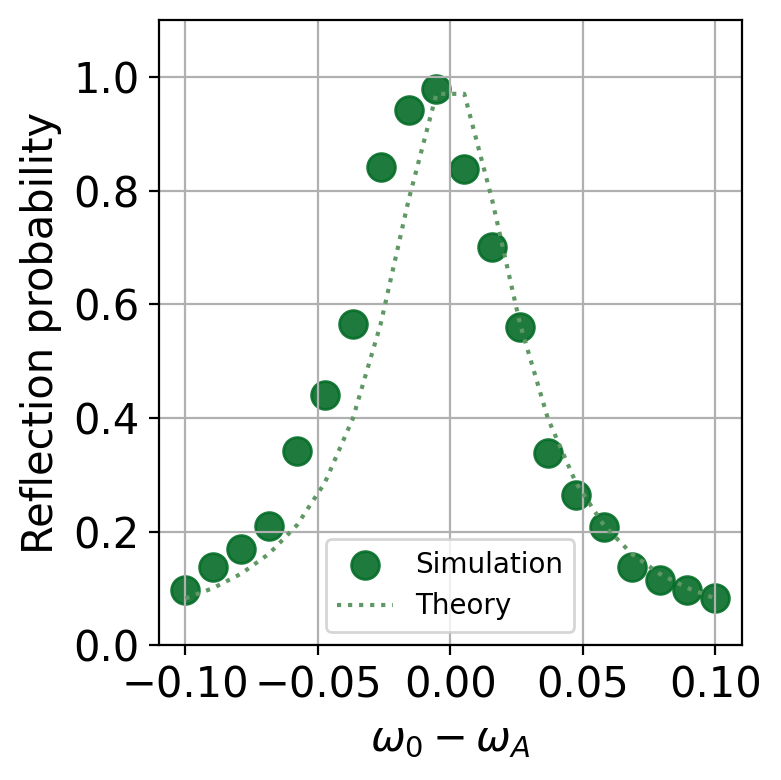

In [124]:
nb_freq_eff = 20

omega_0_tab = np.zeros(nb_freq_eff)
reflection_tab = np.zeros(nb_freq_eff)
transmission_tab = np.zeros(nb_freq_eff)
reflection_sum_tab = np.zeros(nb_freq_eff)
transmission_sum_tab = np.zeros(nb_freq_eff)


for x in range(nb_freq_eff):
    #recover the associated csv file
    current_filename = f"./results_transmission/results_{x}.csv"
    df = pd.read_csv(current_filename)

    omega_0_tab[x] = df['omega_0'][0]
    reflection_tab[x] = df['reflection'][0]
    transmission_tab[x] = df['transmission'][0]
    reflection_sum_tab[x] = df['R_coef_sum'][0]
    transmission_sum_tab[x] = df['T_coef_sum'][0]

theory_curve = 1 / (1 + (omega_0_tab - omega_A)**2 / (g_0**2 * omega_A)**2)

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=resol)
ax.scatter(omega_0_tab - omega_A, reflection_tab, marker='o', label='Simulation', color="#056d28", s=100, alpha=0.9)
ax.plot(omega_0_tab - omega_A, theory_curve, markersize=3, label='Theory', linestyle=':', color="#609865")
ax.set_xlabel(r'$\omega_0 - \omega_A$')
ax.set_ylabel("Reflection probability")
ax.grid()
ax.legend()
ax.set_ylim(0, 1.1)

ax.legend(prop={'size': 10}, loc='lower center')

#font size
for item in [ax.xaxis.label, ax.yaxis.label]:
    item.set_fontsize(15)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

fig.tight_layout()
#plt.savefig('reflection_vs_omega0.pdf', bbox_inches='tight')
plt.show()